In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.applications as keras_apps
import cryptovision.tools as tools
import cryptovision.dataset as dataset
from tensorflow.keras import layers

In [15]:
SEED = 42
image_size = (299, 299)
level = 'family'
epochs = 20

df = dataset.main(min_samples=100)

train_df, val_df, test_df = tools.split_dataframe(
    df,
    test_size=0.15,
    val_size=0.15,
    stratify_by='folder_label',
    random_state=SEED,
)

train_ds = tools.tensorflow_dataset(
    train_df,
    batch_size=128,
    image_size=image_size,
)

val_ds = tools.tensorflow_dataset(
    val_df,
    batch_size=128,
    image_size=image_size,
)

test_ds = tools.tensorflow_dataset(
    test_df,
    batch_size=128,
    image_size=image_size,
)

train_datasets = {
    'all': train_ds,
    'family': train_ds.map(lambda image, labels: (image, labels['family'])),
    'genus': train_ds.map(lambda image, labels: (image, labels['genus'])),
    'species': train_ds.map(lambda image, labels: (image, labels['species'])),
}

val_datasets = {
    'all': val_ds,
    'family': val_ds.map(lambda image, labels: (image, labels['family'])),
    'genus': val_ds.map(lambda image, labels: (image, labels['genus'])),
    'species': val_ds.map(lambda image, labels: (image, labels['species'])),
}

test_datasets = {
    'all': test_ds,
    'family': test_ds.map(lambda image, labels: (image, labels['family'])),
    'genus': test_ds.map(lambda image, labels: (image, labels['genus'])),
    'species': test_ds.map(lambda image, labels: (image, labels['species'])),
}

2025-02-11 17:53:03.573 | INFO     | cryptovision.dataset:main:46 - Processing sjb dataset
2025-02-11 17:53:03.623 | INFO     | cryptovision.dataset:main:46 - Processing scls dataset
2025-02-11 17:53:03.629 | INFO     | cryptovision.dataset:main:46 - Processing lirs dataset
2025-02-11 17:53:03.636 | INFO     | cryptovision.dataset:main:46 - Processing cbc dataset
2025-02-11 17:53:03.641 | INFO     | cryptovision.dataset:main:46 - Processing web dataset
2025-02-11 17:53:03.698 | INFO     | cryptovision.dataset:main:46 - Processing inat dataset
2025-02-11 17:53:03.746 | INFO     | cryptovision.dataset:main:51 - Dataset shape before: (29983, 20)
2025-02-11 17:53:03.749 | INFO     | cryptovision.dataset:main:52 - Fam 29 | Gen 81 | Spec 190
2025-02-11 17:53:03.760 | INFO     | cryptovision.dataset:main:55 - Number of duplicates: 0
2025-02-11 17:53:03.764 | INFO     | cryptovision.dataset:main:58 - Filtration by species with more than 100 images
2025-02-11 17:53:03.764 | INFO     | cryptovis

In [16]:
# Build Model

# Augmentation
augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal", seed=SEED),
        layers.RandomRotation(0.1, seed=SEED),
        layers.RandomZoom(height_factor=(0.05, 0.1), width_factor=(0.05, 0.1), seed=SEED),  # Wider zoom range
        layers.RandomContrast(0.2, seed=SEED),
        layers.RandomBrightness(0.2, seed=SEED),
        layers.RandomTranslation(0.1, 0.1, seed=SEED),
        layers.RandomCrop(image_size[0], image_size[1], seed=SEED),
        layers.GaussianNoise(0.1, seed=SEED),
    ],
    name='augmentation'
)

# Pre-trained Model
pretrain = keras_apps.ResNet50V2(include_top=False, weights='imagenet', input_shape=(image_size[0], image_size[1], 3))
pretrain.trainable = False

def pretrain_model(backbone, preprocess, input_shape=(224, 224, 3), name=None, augmentation=None):
    
    inputs = layers.Input(shape=input_shape, name='input_layer')
    x = augmentation(inputs) if augmentation else inputs
    x = preprocess(x)
    x = backbone(x, training=False)
    
    return tf.keras.Model(inputs, x, name=name)

def dense_block(input_layer, name:str, units:int, dropout:float, activation:str='relu', norm:bool=True):
    
    x = layers.Dense(units, name=name)(input_layer)
    if norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout)(x)
    return x

feature_extractor = pretrain_model(
    pretrain, 
    keras_apps.resnet_v2.preprocess_input, 
    input_shape=(image_size[0], image_size[1], 3), 
    name='feature_extractor',
    augmentation=augmentation
)

# Eviota Model
features = layers.GlobalAveragePooling2D(name='GlobAvgPool2D')(feature_extractor.output)
hidden_layer = dense_block(features, 'hidden_layer', 1024, 0.2)

# Species Output
species_output = layers.Dense(df[level].nunique(), activation='softmax', name='species')(hidden_layer)

model = tf.keras.Model(
    feature_extractor.input,
    species_output,
    name='LevelModel_' + level
)

model.summary()

Model: "LevelModel_family"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_3 (TrueDivide)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 10, 10, 2048)   │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GlobAvgPool2D                   │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer (Dense)            │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ species (Dense)                 │ (None, 21)             │        21,525 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,688,597 (97.99 MB)

 Trainable params: 2,121,749 (8.09 MB)

 Non-trainable params: 23,566,848 (89.90 MB)

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [18]:
history = model.fit(
    train_datasets[level],
    epochs=epochs,
    validation_data=val_datasets[level],
    verbose=1,
)

Epoch 1/20


2025-02-11 17:53:28.814858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 25 of 18735
2025-02-11 17:53:39.161359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 50 of 18735
2025-02-11 17:53:58.829235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 98 of 18735
2025-02-11 17:54:17.863532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4235 - loss: 2.0488

2025-02-11 17:57:40.775911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:96: Filling up shuffle buffer (this may take a while): 20 of 4015
2025-02-11 17:57:45.707366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


147/147 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.4246 - loss: 2.0448 - val_accuracy: 0.7594 - val_loss: 0.9488
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.7493 - loss: 0.8473 - val_accuracy: 0.8005 - val_loss: 0.6665
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.7996 - loss: 0.6694 - val_accuracy: 0.8259 - val_loss: 0.5667
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.8183 - loss: 0.5873 - val_accuracy: 0.8438 - val_loss: 0.5226
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.8401 - loss: 0.5304 - val_accuracy: 0.8501 - val_loss: 0.4919
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.8548 - loss: 0.4826 - val_accuracy: 0.8595 - val_loss: 0.4682
Epoch 7/20
 41/147 ━━━━━━━━━━━━━━━━━━━━ 2:17 1s/step - accuracy: 0.8643 - loss: 0.4254

KeyboardInterrupt: 

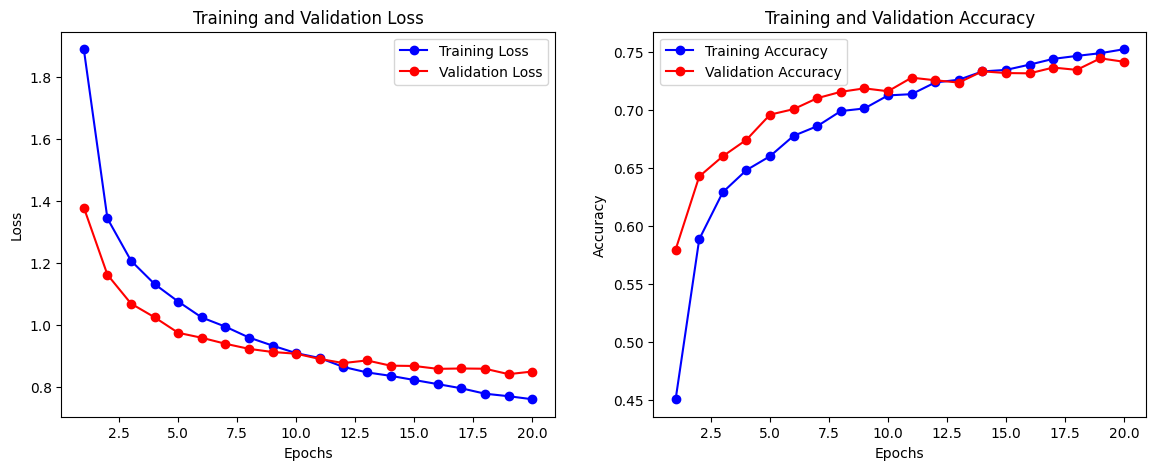

In [19]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss from a Keras History object.
    
    Parameters:
    -----------
    history : keras.callbacks.History
        The History object returned by model.fit().
    """
    # Retrieve metrics from the history object
    acc      = history.history.get('accuracy', [])
    val_acc  = history.history.get('val_accuracy', [])
    loss     = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    
    epochs = range(1, len(loss) + 1)
    
    # Create subplots for loss and accuracy
    plt.figure(figsize=(14, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# Example usage:
plot_training_history(history)


In [15]:
test_ds = tools.tensorflow_dataset(
    test_df,
    batch_size=128,
    image_size=(224, 224),
)

test_ds_sp = test_ds.map(lambda image, labels: (image, labels['species']))

In [ ]:
# Specialist Based Model
def specialist(backbone, preprocess, input_shape, output_units, augmentation=None):

    inputs = layers.Input(shape=input_shape, name='input_layer')
    x = augmentation(inputs) if augmentation else inputs
    x = preprocess(x)
    
    
    # Family Specialist
    fam_features = backbone(x, training=False)
    fam_features = layers.GlobalAveragePooling2D()(fam_features)
    fam_hidden = dense_block(fam_features, 1024, 0.3, 'family_hidden')
    family_output = layers.Dense(output_units[0], activation='softmax', name='family')(fam_hidden)
    
    # Genus Specialist
    genus_features = backbone(x, training=False)
    genus_features = layers.GlobalAveragePooling2D()(genus_features)
    genus_hidden = dense_block(genus_features, 512, 0.3, 'genus_hidden')
    genus_output = layers.Dense(output_units[1], activation='softmax', name='genus')(genus_hidden)
    
    # Species Specialist
    species_features = backbone(x, training=False)
    species_features = layers.GlobalAveragePooling2D()(species_features)
    species_hidden = dense_block(species_features, 512, 0.3, 'species_hidden')
    species_output = layers.Dense(output_units[2], activation='softmax', name='species')(species_hidden)
    
    model = tf.keras.Model(
        inputs,
        [family_output, genus_output, species_output],
        name='Specialist'
    )
    
    return model
    